In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error, r2_score
from pandas.tseries.offsets import DateOffset
from pandas.tseries import offsets
from datetime import timedelta
import statsmodels.api as sm
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [2]:
df=pd.read_csv('Employee_project (after ML).csv')
df=df.iloc[:,1:]
print(df.shape)
df.head()

(5000, 14)


,Call_Id,Date,Agent,Department,Answered,Resolved,Speed_of_Answer,AvgTalkDuration,Satisfaction_rating,Hike,Week_number,duration_in_second,Day,Month
0,ID0001,2015-01-01 09:12:58.000,Diane,Washing Machine,Y,Y,109.0,00:02:23.210000,3.0,0,1,143,1,1
1,ID0002,2015-01-01 09:12:57.600,Becky,Air Conditioner,Y,N,70.0,00:04:02.323000,3.0,0,1,242,1,1
2,ID0003,2015-01-01 09:47:31.200,Stewart,Washing Machine,Y,Y,10.0,00:02:11.202000,3.0,0,1,131,1,1
3,ID0004,2015-01-01 09:47:31.200,Greg,Washing Machine,Y,Y,53.0,00:00:37.481000,2.0,0,1,37,1,1
4,ID0005,2015-01-01 10:00:28.800,Becky,Toaster,Y,Y,95.0,00:01:00.083000,3.0,0,1,60,1,1


### EDA:

In [3]:
df.isna().sum().sum()

0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Call_Id              5000 non-null   object 
 1   Date                 5000 non-null   object 
 2   Agent                5000 non-null   object 
 3   Department           5000 non-null   object 
 4   Answered             5000 non-null   object 
 5   Resolved             5000 non-null   object 
 6   Speed_of_Answer      5000 non-null   float64
 7   AvgTalkDuration      5000 non-null   object 
 8   Satisfaction_rating  5000 non-null   float64
 9   Hike                 5000 non-null   int64  
 10  Week_number          5000 non-null   int64  
 11  duration_in_second   5000 non-null   int64  
 12  Day                  5000 non-null   int64  
 13  Month                5000 non-null   int64  
dtypes: float64(2), int64(5), object(7)
memory usage: 547.0+ KB


In [5]:
df['Date']=pd.to_datetime(df['Date'])
df['Date']=df['Date'].dt.strftime('%m/%d/%Y')
df['Date_2']=pd.to_datetime(df['Date'])
print(df['Date_2'].dtype)
print(df['Date'].dtype)
print(df['Day'].unique())
print(df['Month'].unique())

datetime64[ns]
object
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
[1 2 3]


In [6]:
df_time=df.groupby(['Date_2'])['duration_in_second'].sum().to_frame(name='Total_call_duration')
df_time.index.dtype

dtype('<M8[ns]')

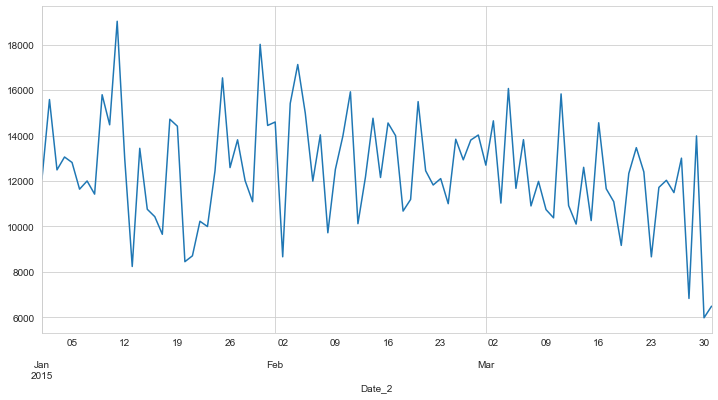

In [7]:
plt.rcParams['figure.figsize']=12,6
df_time['Total_call_duration'].plot()

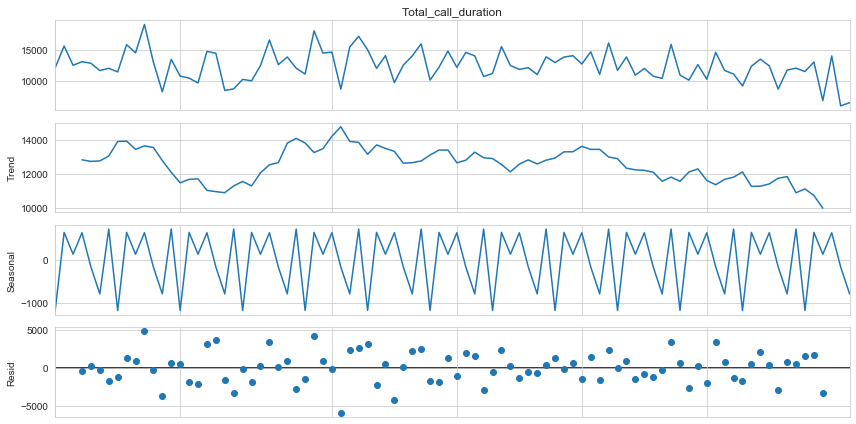

In [8]:
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
decomposition=seasonal_decompose(df_time['Total_call_duration'], model='additive', period=7).plot()
plt.show()

### Checking Stationarity:

- H0: Time series is not stationary
- H1: time series is stationary

In [10]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks([])
    plt.show()
    
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

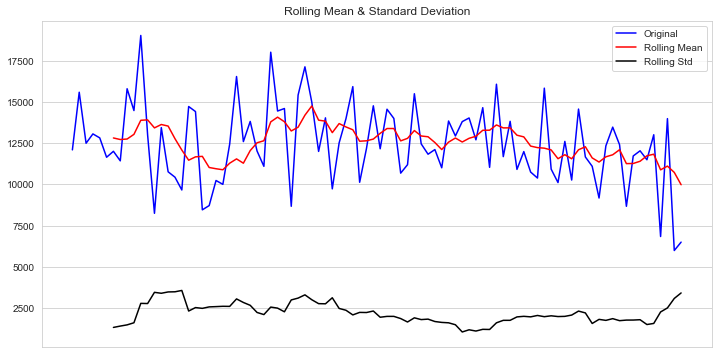

Results of Dickey-Fuller Test:
Test Statistic                -8.187112e+00
p-value                        7.845533e-13
#Lags Used                     0.000000e+00
Number of Observations Used    8.900000e+01
Critical Value (1%)           -3.506057e+00
Critical Value (5%)           -2.894607e+00
Critical Value (10%)          -2.584410e+00
dtype: float64


In [11]:
test=test_stationarity(df_time['Total_call_duration'])

Here p-value is smaller than significant level (alpha=0.05), therefore we will reject Null Hypothesis. Hence the time series is stationary.

### Calculating AR(p) and MA (q) values:

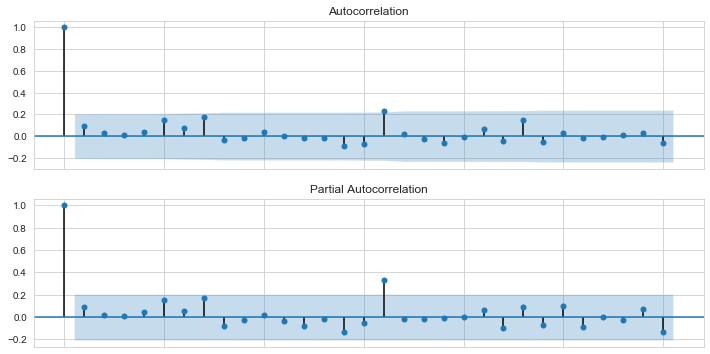

In [12]:
plt.figure()
plt.subplot(211)
plot_acf(df_time, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(df_time, ax=plt.gca(), lags = 30)
plt.show()

In [13]:
df_time.head()

,Total_call_duration
Date_2,
2015-01-01,12088
2015-01-02,15585
2015-01-03,12490
2015-01-04,13057
2015-01-05,12816


### Modelling:

In [14]:
model=sm.tsa.statespace.SARIMAX(df_time['Total_call_duration'], freq='D', 
                                order=(1,0,1), seasonal_order=(1,0,1,7)).fit(max_iter=1000)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:               Total_call_duration   No. Observations:                   90
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -827.860
Date:                           Sun, 04 Jul 2021   AIC                           1665.720
Time:                                   21:10:58   BIC                           1678.219
Sample:                               01-01-2015   HQIC                          1670.761
                                    - 03-31-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   4265.998      0.000       0.999       1.000
ma.L1         -0.9282      0.055    -16.860      0.000      -1.036      -0.820
ar.S.L7       -0.6369      0.276     -2.311      0.021      -1.177      -0.097
ma.S.L7        0.9049      0.279      3.242      0.001       0.358       1.452
sigma2      5.366e+06      1e-07   5.35e+13      0.000    5.37e+06    5.37e+06
===================================================================================
Ljung-Box (Q):                       18.89   Jarque-Bera (JB):                 0.17
Prob(Q):                              1.00   Prob(JB):                         0.92
Heteroskedasticity (H):               0.85   Skew:                             0.09
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.58e+28. Standard errors may be unstable.
"""

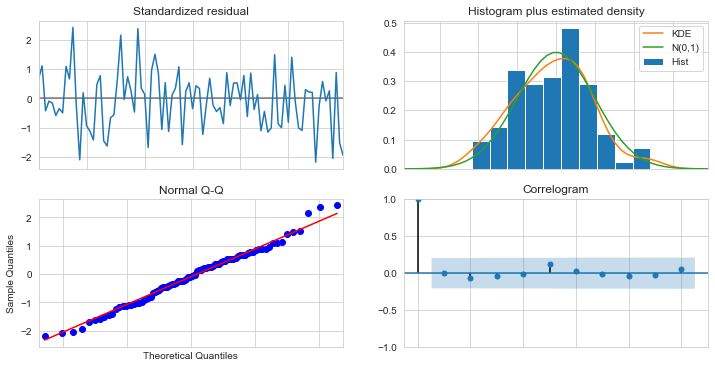

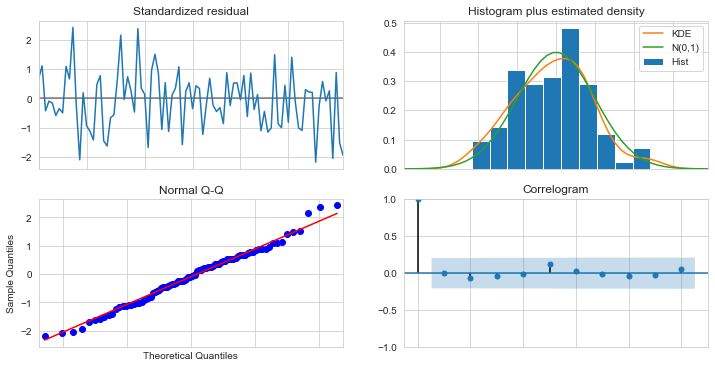

In [16]:
model.plot_diagnostics()

### Evaluation:

In [22]:
start_index=df_time.index.min()
end_index=df_time.index.max()
print(start_index)
print(end_index)
df_time['Forecast']=model.predict(start=start_index, end=end_index)

2015-01-01 00:00:00
2015-03-31 00:00:00


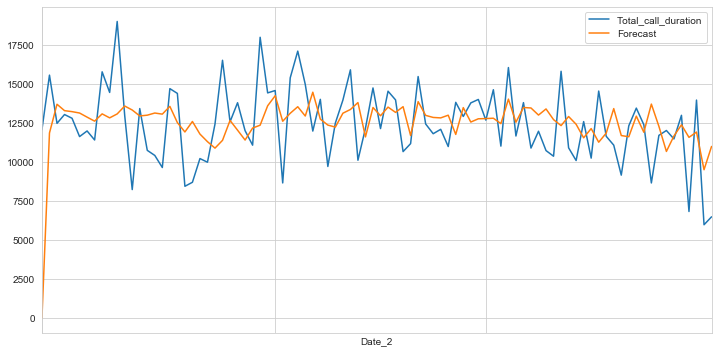

In [26]:
df_time[['Total_call_duration', 'Forecast']].plot()

In [53]:
def evaluate_forecast(y, pred):
    results = pd.DataFrame({'mean_absolute_error':mean_absolute_error(y, pred)}, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [54]:
evaluate=evaluate_forecast(df_time['Total_call_duration'], df_time['Forecast'])
evaluate

,mean_absolute_error,median_absolute_error,mse,msle,rmse
0,1996.715159,1559.23821,7.066863e+06,1.021735,2658.357205


NormaltestResult(statistic=27.585517100916, pvalue=1.023012808589315e-06)


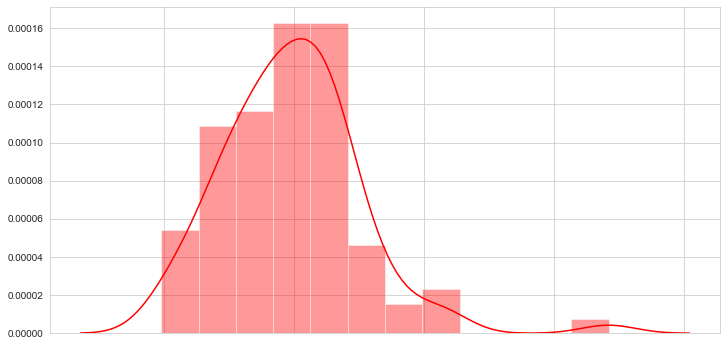

In [29]:
plt.rcParams['figure.figsize']=12,6
residual=model.resid
print(normaltest(residual))
sns.distplot(residual, color='red')

This residual plot is almost following normal distribution. Also, the residuals have mean nearly equal to zero. This means that the prediction is unbiased.

### Forecasting:

In [31]:
future_dates=[pd.to_datetime(df_time.index[-1], format='%m/%d/%Y')+timedelta(days=x) for x in range(0, 90)]  #Increment of date by 1 month.

In [32]:
future_dates[:5]

[Timestamp('2015-03-31 00:00:00'),
 Timestamp('2015-04-01 00:00:00'),
 Timestamp('2015-04-02 00:00:00'),
 Timestamp('2015-04-03 00:00:00'),
 Timestamp('2015-04-04 00:00:00')]

In [34]:
future_datest_df=pd.DataFrame(index=future_dates[1:], columns=df_time.columns)
print(future_datest_df.shape)
future_datest_df.head()

(89, 2)


,Total_call_duration,Forecast
2015-04-01,NaN,NaN
2015-04-02,NaN,NaN
2015-04-03,NaN,NaN
2015-04-04,NaN,NaN
2015-04-05,NaN,NaN


In [35]:
future_df=pd.concat([df_time, future_datest_df])
print(future_df.shape)
future_df.tail()

(179, 2)


,Total_call_duration,Forecast
2015-06-24,NaN,NaN
2015-06-25,NaN,NaN
2015-06-26,NaN,NaN
2015-06-27,NaN,NaN
2015-06-28,NaN,NaN


In [36]:
future_df.index.dtype

dtype('<M8[ns]')

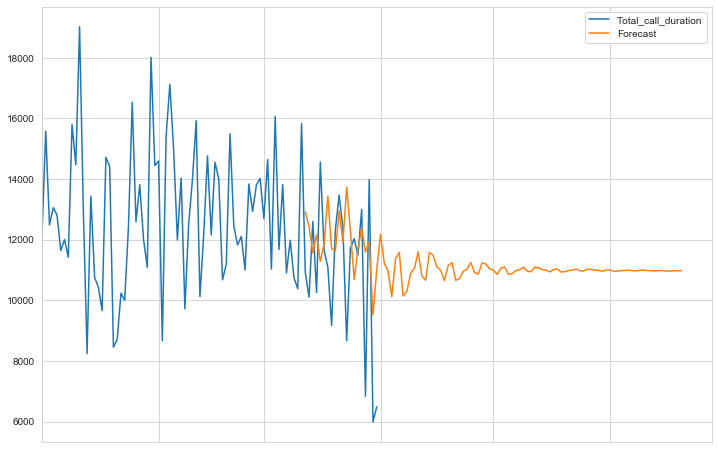

In [41]:
future_df['Forecast']=model.predict(start = 70, end = 170)  #from 90th row to last row of future_dataset
future_df[['Total_call_duration', 'Forecast']].plot(figsize=(12, 8))